Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [41]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import random
import cv2
import seaborn as sns
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Dropout
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import load_img

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Set the seed for reproducibility
seed = 123

# Defining the path for train and test images
path_to_train_directory = '/content/gdrive/My Drive/Dataset/Melanoma/Train'
path_to_test_directory = '/content/gdrive/My Drive/Dataset/Melanoma/Test'
data_dir_train = pathlib.Path(path_to_train_directory)
data_dir_test = pathlib.Path(path_to_test_directory)


In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('Train image count - ',image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('Test image count - ',image_count_test)

Train image count -  2250
Test image count -  118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Train dataset
image_size = (img_height, img_width)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=seed,
    label_mode='categorical',
    image_size=image_size,
    batch_size = batch_size
)

Found 2250 files belonging to 9 classes.
Using 1800 files for training.


In [7]:
## Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    label_mode='categorical',
    image_size=image_size,
    batch_size = batch_size
)

Found 2250 files belonging to 9 classes.
Using 450 files for validation.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=seed,
    label_mode='categorical',
    image_size=image_size,
    batch_size = batch_size
)

Found 118 files belonging to 9 classes.


In [9]:
# List of classes of skin cancer
class_names = val_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data per class


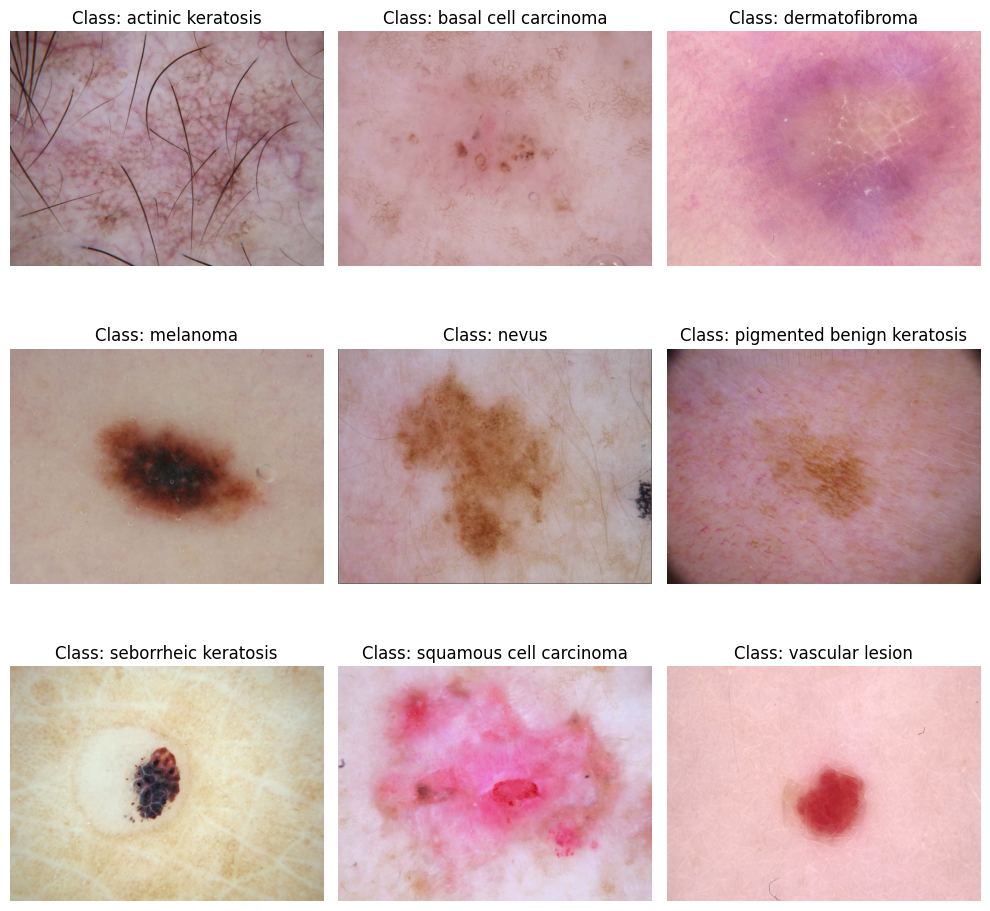

In [10]:
import matplotlib.pyplot as plt
from pathlib import Path
data_dir_train = Path(path_to_train_directory)
# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Iterate over class names
for i, cn in enumerate(class_names):
    # Get the first image file for the current class
    image_file = list(data_dir_train.glob(f'{cn}/*.jpg'))[0]

    # Load and display the image
    skin_image = tf.keras.preprocessing.image.load_img(image_file)

    # Plot the image in the corresponding subplot
    ax = axes[i // 3, i % 3]
    ax.imshow(skin_image)
    ax.set_title(f'Class: {cn}')
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()



The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create a CNN model
#### Normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(256, activation='relu'),

    layers.Dense(9, activation='softmax')  # 9 classes in the output layer
])


#### Compile model
- Loss function - categorical_crossentropy
- Optimizer - sgd

In [13]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                   

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 323s 1s/step - loss: 2.0424 - accuracy: 0.1828 - val_loss: 2.0392 - val_accuracy: 0.1956
Epoch 2/20
57/57 [==============================] - 3s 61ms/step - loss: 2.0143 - accuracy: 0.2372 - val_loss: 2.0270 - val_accuracy: 0.2289
Epoch 3/20
57/57 [==============================] - 3s 61ms/step - loss: 1.9987 - accuracy: 0.2556 - val_loss: 2.0037 - val_accuracy: 0.1867
Epoch 4/20
57/57 [==============================] - 4s 64ms/step - loss: 1.9785 - accuracy: 0.2594 - val_loss: 1.9680 - val_accuracy: 0.2600
Epoch 5/20
57/57 [==============================] - 4s 65ms/step - loss: 1.9495 - accuracy: 0.2872 - val_loss: 1.9459 - val_accuracy: 0.2578
Epoch 6/20
57/57 [==============================] - 4s 62ms/step - loss: 1.9502 - accuracy: 0.2839 - val_loss: 1.9085 - val_accuracy: 0.2800
Epoch 7/20
57/57 [==============================] - 4s 63ms/step - loss: 1.8995 - accuracy: 0.3139 - val_loss: 1.8657 - val_accuracy: 0.3578
Epoch 8/20
57

### Visualizing training results

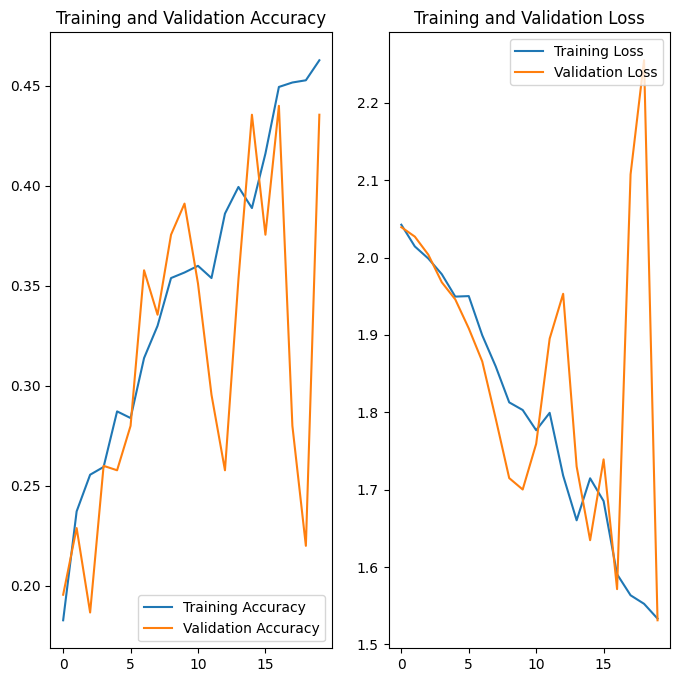

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### *Observation-*
#### It is observed that validation accuracy is fluctuating alot indicating that the model is highly overfitted

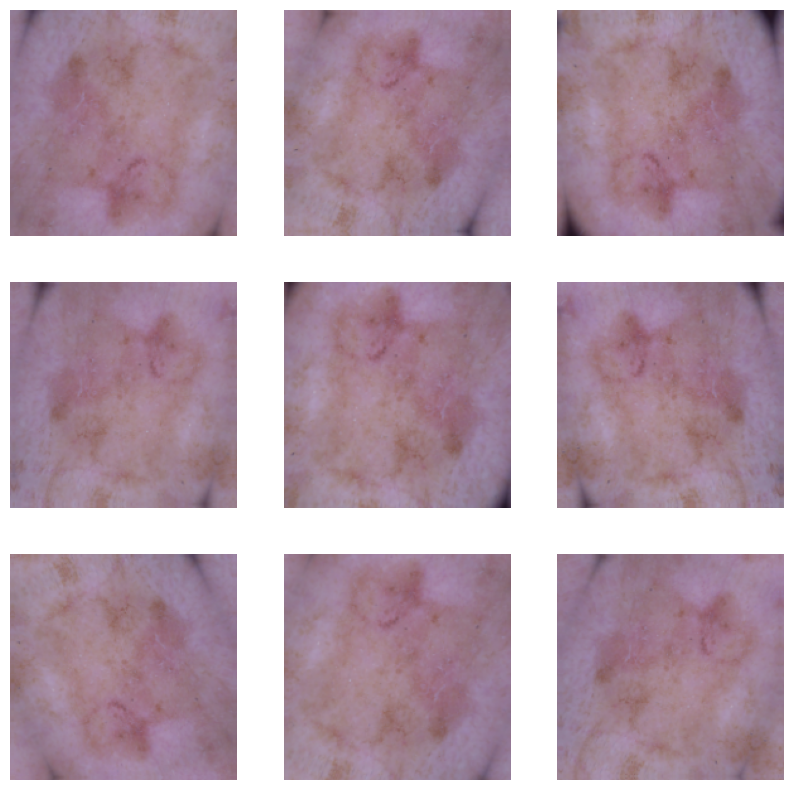

In [17]:
# Data augumentation strategy to handle overfitting
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1)
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Create the model, compile and train the model


In [18]:
## Added Dropout layer to handle overfitting

model = tf.keras.Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)),  # Normalize pixel values

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    Dropout(0.2),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.2),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.2),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.2),

    layers.Flatten(),

    layers.Dense(512, activation='relu'),
    Dropout(0.2),

    layers.Dense(9, activation='softmax')  # 9 classes in the output layer
])



### Compiling the model

In [19]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

### Training the model

In [20]:
history = epochs = 20
batch_size_t = 32
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 9s 115ms/step - loss: 2.0492 - accuracy: 0.1844 - val_loss: 2.1280 - val_accuracy: 0.1867
Epoch 2/20
57/57 [==============================] - 6s 107ms/step - loss: 2.0252 - accuracy: 0.1994 - val_loss: 2.1195 - val_accuracy: 0.1867
Epoch 3/20
57/57 [==============================] - 6s 110ms/step - loss: 2.0167 - accuracy: 0.2200 - val_loss: 2.1346 - val_accuracy: 0.2067
Epoch 4/20
57/57 [==============================] - 6s 108ms/step - loss: 2.0008 - accuracy: 0.2289 - val_loss: 2.1218 - val_accuracy: 0.2600
Epoch 5/20
57/57 [==============================] - 6s 110ms/step - loss: 1.9852 - accuracy: 0.2383 - val_loss: 2.1257 - val_accuracy: 0.2933
Epoch 6/20
57/57 [==============================] - 6s 111ms/step - loss: 1.9634 - accuracy: 0.2672 - val_loss: 2.1176 - val_accuracy: 0.2356
Epoch 7/20
57/57 [==============================] - 6s 108ms/step - loss: 1.9593 - accuracy: 0.2856 - val_loss: 2.1146 - val_accuracy: 0.3022
Epoch 


Observation
---



### Visualizing the results

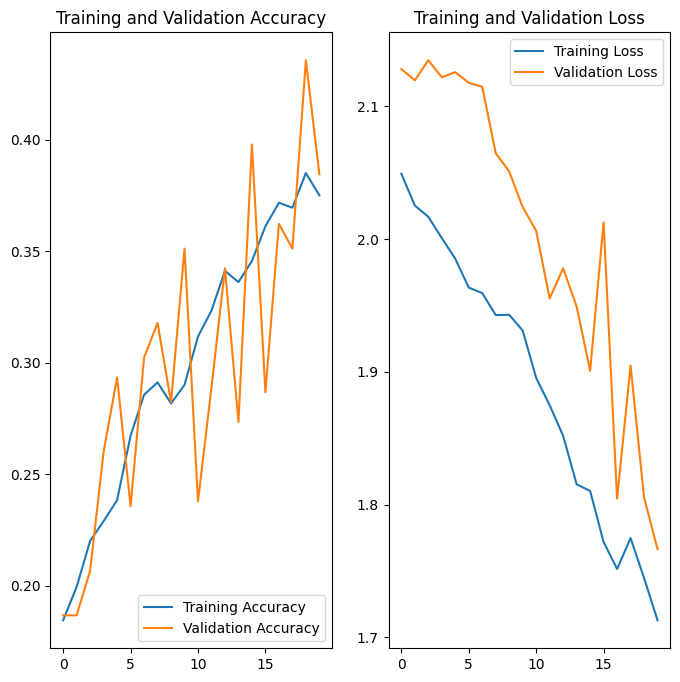

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### The amount of overfitting has reduced but needs to be reduced further.
### Also, accuracy need to be improved

#### **Distribution of classes in the training dataset**
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,vascular lesion,139
1,squamous cell carcinoma,191
2,pigmented benign keratosis,462
3,dermatofibroma,95
4,actinic keratosis,115
5,nevus,357
6,melanoma,438
7,basal cell carcinoma,376
8,seborrheic keratosis,77


<Axes: xlabel='No. of Image', ylabel='Class'>

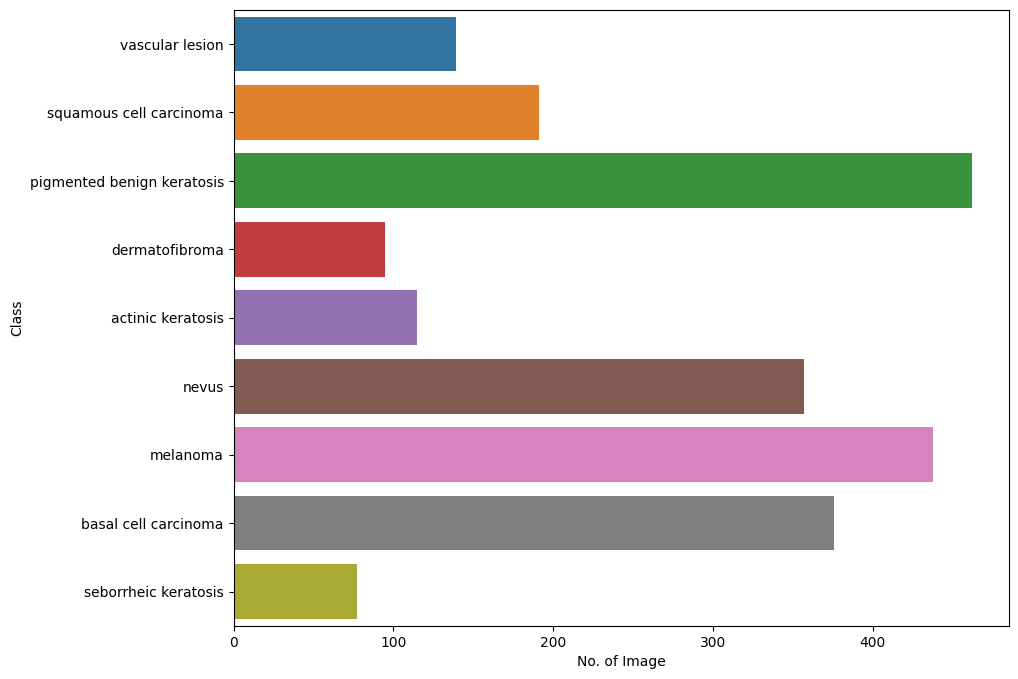

In [23]:
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

#### - seborrheic keratosis has the least number of samples - 77
#### - pigmented benign keratosis and melanoma dominate the data in terms proportionate number of samples


#### **Class Imbalance is observed**
#### Rectification of class imbalance by using `Augmentor` (https://augmentor.readthedocs.io/en/master/). It adds more samples across all classes so that none of the classes have very few samples.

In [24]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
path_to_training_dataset= '/content/gdrive/My Drive/Dataset/Melanoma/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 115 image(s) found.
Output directory set to /content/gdrive/My Drive/Dataset/Melanoma/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78ABB6102FE0>: 100%|██████████| 500/500 [00:21<00:00, 23.25 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Dataset/Melanoma/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78ABBAE37010>: 100%|██████████| 500/500 [00:23<00:00, 20.91 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Dataset/Melanoma/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78ABBADC80A0>: 100%|██████████| 500/500 [00:23<00:00, 21.71 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Dataset/Melanoma/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78AC4816BD60>: 100%|██████████| 500/500 [01:28<00:00,  5.65 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Dataset/Melanoma/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x78AC48182AD0>: 100%|██████████| 500/500 [01:22<00:00,  6.07 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Dataset/Melanoma/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78ABA971FFD0>: 100%|██████████| 500/500 [00:18<00:00, 26.66 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Dataset/Melanoma/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78AC481535E0>: 100%|██████████| 500/500 [00:40<00:00, 12.20 Samples/s]


Initialised with 191 image(s) found.
Output directory set to /content/gdrive/My Drive/Dataset/Melanoma/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78AC39F91D80>: 100%|██████████| 500/500 [00:18<00:00, 27.61 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Dataset/Melanoma/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78ABB60BDFC0>: 100%|██████████| 500/500 [00:17<00:00, 27.88 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list_new

In [28]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [29]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [30]:
#df2 = pd.DataFrame({'Path': path_list_new, 'Label': lesion_list_new})
#new_df = train_ds.append(df2)

In [31]:
#df2

In [32]:
#new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

#### Training dataset

In [34]:
data_dir_train=path_to_training_dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=seed,
  label_mode='categorical',
  image_size=image_size)

Found 6750 files belonging to 9 classes.
Using 5400 files for training.


#### Validation dataset

In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  label_mode='categorical',
  image_size=image_size,
  batch_size = batch_size)

Found 6750 files belonging to 9 classes.
Using 1350 files for validation.


#### Create model with normalization

In [36]:
## Dropout layer added to reduce overfitting

model = tf.keras.Sequential([
    #data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)),  # Normalize pixel values
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    Dropout(0.2),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.2),
    #layers.BatchNormalization(),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.2),
    #layers.BatchNormalization(),

    layers.Flatten(),

    Dropout(0.2),
    layers.Dense(256, activation='relu'),

    layers.Dense(9, activation='softmax')  # 9 classes in the output layer
])


#### Compile model
- Loss function - categorical_crossentropy
- Optimizer - sgd

In [37]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])


#### Train model

In [38]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 55s 313ms/step - loss: 2.1696 - accuracy: 0.1643 - val_loss: 2.1667 - val_accuracy: 0.1770
Epoch 2/30
169/169 [==============================] - 40s 223ms/step - loss: 2.0610 - accuracy: 0.2178 - val_loss: 2.0626 - val_accuracy: 0.2896
Epoch 3/30
169/169 [==============================] - 39s 226ms/step - loss: 1.9569 - accuracy: 0.2669 - val_loss: 1.9985 - val_accuracy: 0.3000
Epoch 4/30
169/169 [==============================] - 40s 231ms/step - loss: 1.8683 - accuracy: 0.2941 - val_loss: 2.0266 - val_accuracy: 0.1978
Epoch 5/30
169/169 [==============================] - 38s 216ms/step - loss: 1.7780 - accuracy: 0.3344 - val_loss: 1.7825 - val_accuracy: 0.3644
Epoch 6/30
169/169 [==============================] - 38s 220ms/step - loss: 1.6909 - accuracy: 0.3813 - val_loss: 1.8135 - val_accuracy: 0.2837
Epoch 7/30
169/169 [==============================] - 40s 227ms/step - loss: 1.5972 - accuracy: 0.4141 - val_loss: 1.6032 - val_ac

#### Visualize the model results

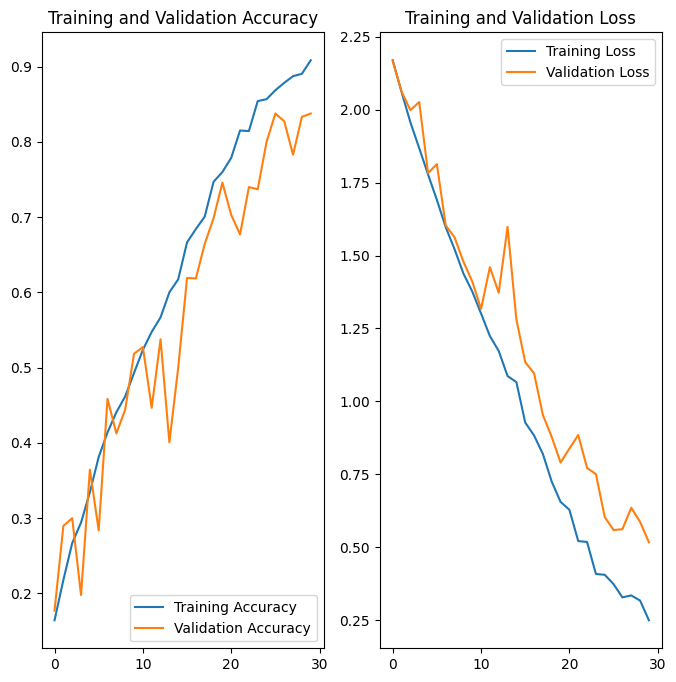

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Final analysis**  
#### Overfitting have been improved with accuracy of 90% and validation accuracy of 83%



## Model Prediction


1/1 [==============================] - 0s 18ms/step
Actual Class melanoma
Predictive Class melanoma


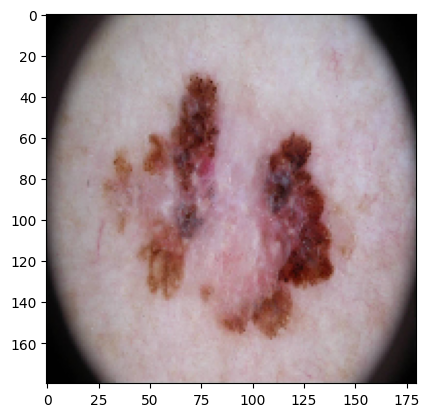

In [65]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[3], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-9],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[3] +'\n'+ "Predictive Class "+pred_class )